# Sales & Demand Forecasting (Future Interns – Task 1)

Dataset: Sample – Superstore (orders from 2014–2017)  



In [32]:
# If running in a fresh environment, install common libs (uncomment if needed)
# !pip -q install pandas numpy matplotlib scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge
# Load Pandas
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [33]:
DATA_PATH = r"/content/Sample - Superstore.csv"

df = pd.read_csv(DATA_PATH, encoding_errors="ignore")
print("Rows, Cols:", df.shape)
df.head()


Rows, Cols: (9994, 21)


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


## 1) Clean & prepare the data



In [34]:
df["Order Date"] = pd.to_datetime(df["Order Date"], errors="coerce")

# Basic checks
print("Missing Order Date:", df["Order Date"].isna().sum())
print("Missing Sales:", df["Sales"].isna().sum())

# Keep only columns we need for this forecasting task
df = df[["Order Date", "Sales"]].dropna()

# Aggregate to daily total sales
daily = (df.groupby("Order Date", as_index=False)["Sales"].sum()
           .rename(columns={"Sales": "sales"}))

# Create a complete daily date range and fill missing days with 0 sales
full_range = pd.date_range(daily["Order Date"].min(), daily["Order Date"].max(), freq="D")
daily = (daily.set_index("Order Date")
              .reindex(full_range)
              .fillna(0.0)
              .rename_axis("date")
              .reset_index())

print(daily.head())
print("Date range:", daily["date"].min().date(), "→", daily["date"].max().date())
print("Total days:", len(daily))


Missing Order Date: 0
Missing Sales: 0
        date     sales
0 2014-01-03    16.448
1 2014-01-04   288.060
2 2014-01-05    19.536
3 2014-01-06  4407.100
4 2014-01-07    87.158
Date range: 2014-01-03 → 2017-12-30
Total days: 1458


## 2) Quick exploration (trend + seasonality)



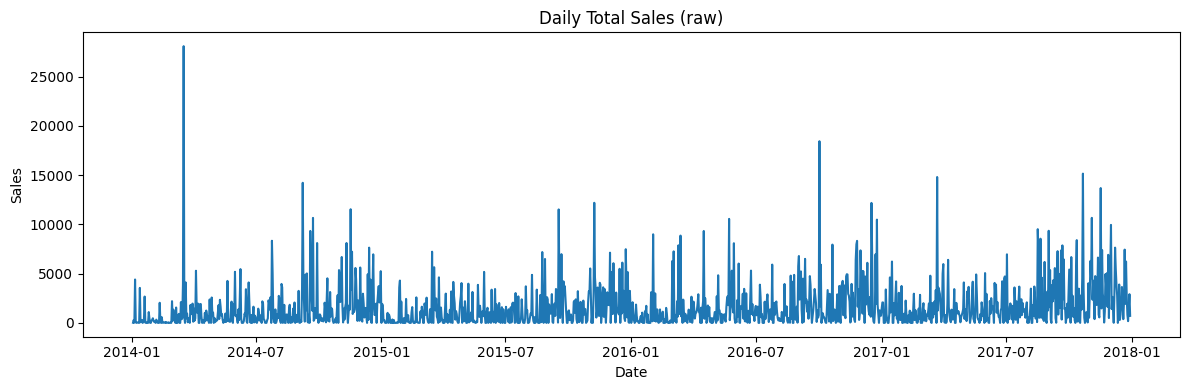

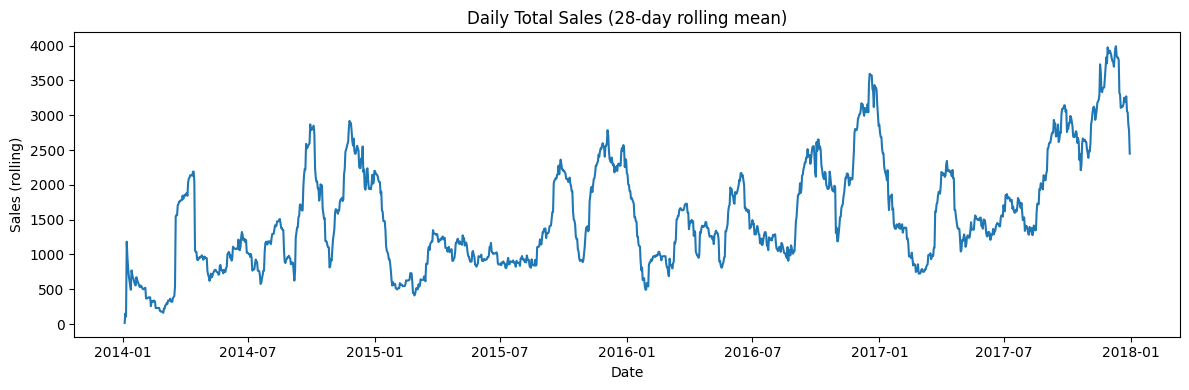

In [35]:
daily["sales_rolling_28"] = daily["sales"].rolling(28, min_periods=1).mean()

plt.figure(figsize=(12,4))
plt.plot(daily["date"], daily["sales"])
plt.title("Daily Total Sales (raw)")
plt.xlabel("Date"); plt.ylabel("Sales")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(daily["date"], daily["sales_rolling_28"])
plt.title("Daily Total Sales (28-day rolling mean)")
plt.xlabel("Date"); plt.ylabel("Sales (rolling)")
plt.tight_layout()
plt.show()


<Figure size 1000x400 with 0 Axes>

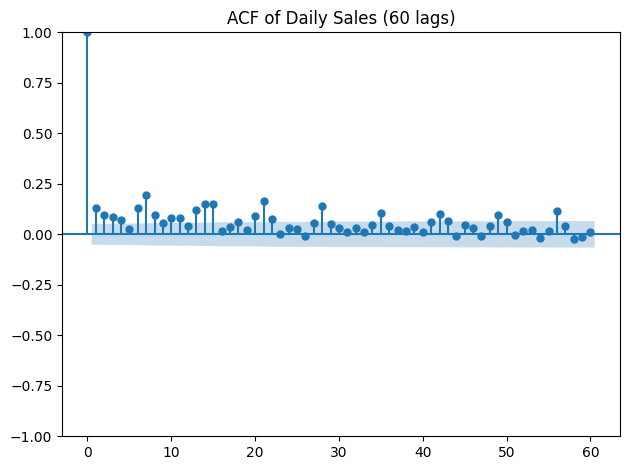

<Figure size 1000x400 with 0 Axes>

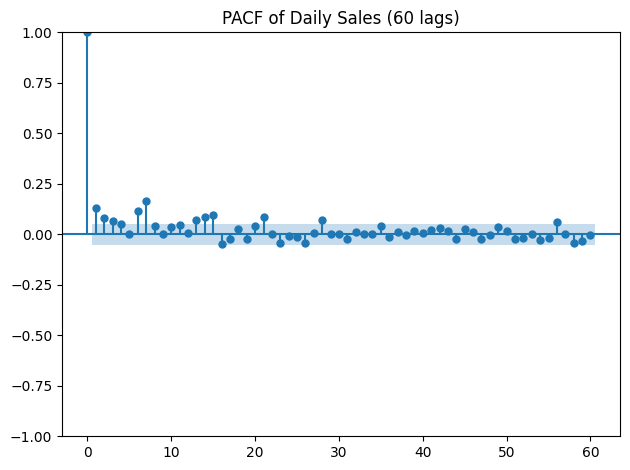

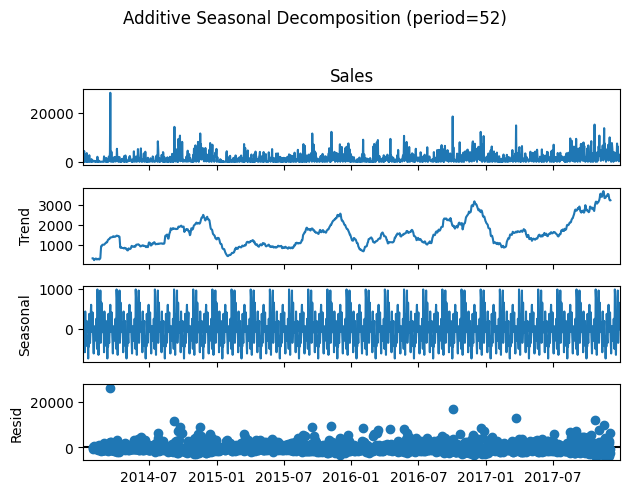

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

df = pd.read_csv("Sample - Superstore.csv", encoding="ISO-8859-1")
df["Order Date"] = pd.to_datetime(df["Order Date"])
daily_sales = (
    df.groupby("Order Date")["Sales"]
      .sum()
      .asfreq("D")          # daily frequency
      .fillna(0)            # fill missing days
)

# Plot ACF with 60 lags
plt.figure(figsize=(10, 4))
plot_acf(daily_sales, lags=60)
plt.title("ACF of Daily Sales (60 lags)")
plt.tight_layout()
plt.show()

# Plot PACF with 60 lags
plt.figure(figsize=(10, 4))
plot_pacf(daily_sales, lags=60, method="ywm")  # stable method
plt.title("PACF of Daily Sales (60 lags)")
plt.tight_layout()
plt.show()

# Additive seasonal decomposition with period=52
# (period=52 implies a 52-day seasonal cycle; for weekly seasonality on daily data, use period=7)
decomp = seasonal_decompose(daily_sales, model="additive", period=52)

decomp.plot()
plt.suptitle("Additive Seasonal Decomposition (period=52)", y=1.02)
plt.tight_layout()
plt.show()

## 3) Feature engineering (time-based + lags)




In [37]:
data = daily.copy()

# Calendar features
data["year"] = data["date"].dt.year
data["month"] = data["date"].dt.month
data["day"] = data["date"].dt.day
data["dayofweek"] = data["date"].dt.dayofweek  # 0=Mon
data["weekofyear"] = data["date"].dt.isocalendar().week.astype(int)
data["quarter"] = data["date"].dt.quarter
data["is_month_start"] = data["date"].dt.is_month_start.astype(int)
data["is_month_end"] = data["date"].dt.is_month_end.astype(int)

# Lag features
for lag in [1, 7, 14, 28]:
    data[f"lag_{lag}"] = data["sales"].shift(lag)

# Rolling means (shifted by 1 to avoid "peeking" into the future)
data["roll_mean_7"]  = data["sales"].shift(1).rolling(7).mean()
data["roll_mean_28"] = data["sales"].shift(1).rolling(28).mean()

# Drop rows with NaN due to lags/rolling
data_ml = data.dropna().reset_index(drop=True)

feature_cols = [
    "year","month","day","dayofweek","weekofyear","quarter","is_month_start","is_month_end",
    "lag_1","lag_7","lag_14","lag_28","roll_mean_7","roll_mean_28"
]
X = data_ml[feature_cols]
y = data_ml["sales"]

print("ML rows:", len(data_ml), "Features:", len(feature_cols))
data_ml.head()


ML rows: 1430 Features: 14


,date,sales,sales_rolling_28,year,month,day,dayofweek,weekofyear,quarter,is_month_start,is_month_end,lag_1,lag_7,lag_14,lag_28,roll_mean_7,roll_mean_28
0,2014-01-31,290.666,507.873107,2014,1,31,4,5,1,0,1,240.500,0.000,0.000,16.448,252.621143,498.079607
1,2014-02-01,468.900,514.331679,2014,2,1,5,5,1,1,0,290.666,0.000,64.864,288.060,294.144857,507.873107
2,2014-02-02,211.646,521.192750,2014,2,2,6,5,1,0,0,468.900,1097.250,378.594,19.536,361.130571,514.331679
3,2014-02-03,97.112,367.264607,2014,2,3,0,6,1,0,0,211.646,426.670,2673.870,4407.100,234.615714,521.192750
4,2014-02-04,134.384,368.951250,2014,2,4,1,6,1,0,0,97.112,3.928,25.248,87.158,187.536000,367.264607


## 4) Train/Test split (time-based)




In [38]:
# Hold out the last ~90 days as a test set
test_days = 90
train_df = data_ml.iloc[:-test_days].copy()
test_df  = data_ml.iloc[-test_days:].copy()

X_train, y_train = train_df[feature_cols], train_df["sales"]
X_test,  y_test  = test_df[feature_cols],  test_df["sales"]

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Test period:", test_df["date"].min().date(), "→", test_df["date"].max().date())


Train: (1340, 14) Test: (90, 14)
Test period: 2017-10-02 → 2017-12-30


## 5) Models


In [39]:
def rmse(y_true, y_pred):
    return root_mean_squared_error(y_true, y_pred)

def safe_mape(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = np.maximum(np.abs(y_true), eps)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100

# 1) Baseline: seasonal naive (7-day lag)
baseline_pred = test_df["lag_7"].values

results = []

def eval_model(name, y_true, y_pred):
    return {
        "model": name,
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": rmse(y_true, y_pred),
        "MAPE_%": safe_mape(y_true, y_pred)
    }

results.append(eval_model("Seasonal naive (lag_7)", y_test, baseline_pred))

# 2) Ridge
ridge = Ridge(alpha=1.0, random_state=42)
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)
results.append(eval_model("Ridge", y_test, ridge_pred))

# 3) Gradient Boosting
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)
gbr_pred = gbr.predict(X_test)
results.append(eval_model("GradientBoostingRegressor", y_test, gbr_pred))

# 4) Random Forest
rf = RandomForestRegressor(
    n_estimators=400,
    random_state=42,
    n_jobs=-1,
    min_samples_leaf=2
)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
results.append(eval_model("RandomForestRegressor", y_test, rf_pred))

pd.DataFrame(results).sort_values("RMSE")

,model,MAE,RMSE,MAPE_%
3,RandomForestRegressor,2040.080566,2940.770404,5.429687e+11
2,GradientBoostingRegressor,2093.243702,2987.589856,5.897805e+11
1,Ridge,2143.485464,3006.909251,8.086095e+11
0,Seasonal naive (lag_7),2807.325091,4119.004458,1.636796e+11


In [40]:
res_df = pd.DataFrame(results).sort_values("RMSE").reset_index(drop=True)
best_name = res_df.loc[0, "model"]
print("Best model:", best_name)
res_df

Best model: RandomForestRegressor


,model,MAE,RMSE,MAPE_%
0,RandomForestRegressor,2040.080566,2940.770404,5.429687e+11
1,GradientBoostingRegressor,2093.243702,2987.589856,5.897805e+11
2,Ridge,2143.485464,3006.909251,8.086095e+11
3,Seasonal naive (lag_7),2807.325091,4119.004458,1.636796e+11


## 6) Pick the best model + visualize predictions



In [41]:
res_df = pd.DataFrame(results).sort_values("RMSE").reset_index(drop=True)
best_name = res_df.loc[0, "model"]
print("Best model:", best_name)
res_df


Best model: RandomForestRegressor


,model,MAE,RMSE,MAPE_%
0,RandomForestRegressor,2040.080566,2940.770404,5.429687e+11
1,GradientBoostingRegressor,2093.243702,2987.589856,5.897805e+11
2,Ridge,2143.485464,3006.909251,8.086095e+11
3,Seasonal naive (lag_7),2807.325091,4119.004458,1.636796e+11


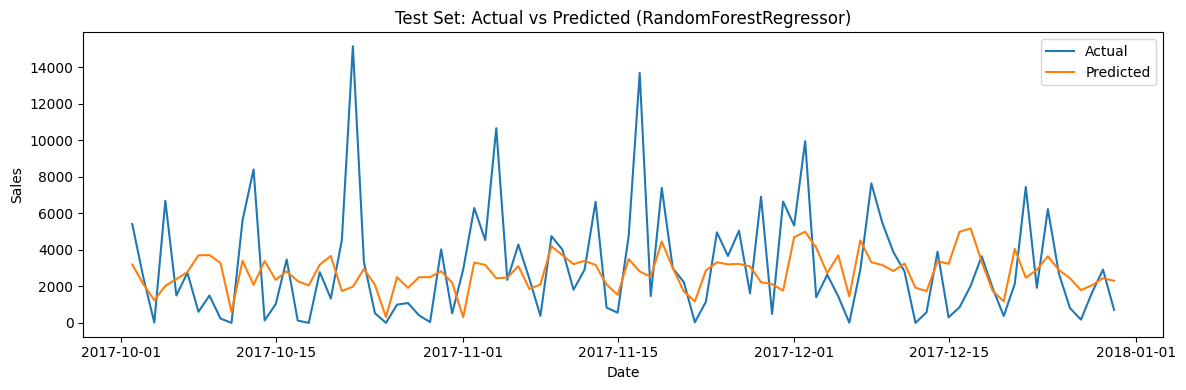

In [42]:
# Choose best fitted model object
best_model = None
best_pred = None

if best_name == "Seasonal naive (lag_7)":
    best_model = None
    best_pred = baseline_pred
elif best_name == "Ridge":
    best_model = ridge
    best_pred = ridge_pred
elif best_name == "GradientBoostingRegressor":
    best_model = gbr
    best_pred = gbr_pred
elif best_name == "RandomForestRegressor":
    best_model = rf
    best_pred = rf_pred

plot_df = test_df[["date"]].copy()
plot_df["actual"] = y_test.values
plot_df["pred"] = best_pred

plt.figure(figsize=(12,4))
plt.plot(plot_df["date"], plot_df["actual"], label="Actual")
plt.plot(plot_df["date"], plot_df["pred"], label="Predicted")
plt.title(f"Test Set: Actual vs Predicted ({best_name})")
plt.xlabel("Date"); plt.ylabel("Sales")
plt.legend()
plt.tight_layout()
plt.show()


## 7) Forecast the next 30 days




In [43]:
HORIZON = 30

# Start from the last available row in the original daily series
history = daily[["date","sales"]].copy().reset_index(drop=True)

# Residual-based uncertainty (simple)
residuals = plot_df["actual"] - plot_df["pred"]
resid_std = residuals.std()
print("Residual std (test):", resid_std)

future_rows = []

for step in range(1, HORIZON+1):
    future_date = history["date"].iloc[-1] + pd.Timedelta(days=1)

    # Build one-row feature frame using *current* history (includes predicted values as they get appended)
    tmp = pd.DataFrame({"date":[future_date]})
    tmp["year"] = tmp["date"].dt.year
    tmp["month"] = tmp["date"].dt.month
    tmp["day"] = tmp["date"].dt.day
    tmp["dayofweek"] = tmp["date"].dt.dayofweek
    tmp["weekofyear"] = tmp["date"].dt.isocalendar().week.astype(int)
    tmp["quarter"] = tmp["date"].dt.quarter
    tmp["is_month_start"] = tmp["date"].dt.is_month_start.astype(int)
    tmp["is_month_end"] = tmp["date"].dt.is_month_end.astype(int)

    # Lags from history
    def get_lag(k):
        if len(history) - k < 0:
            return np.nan
        return float(history["sales"].iloc[-k])
    tmp["lag_1"]  = get_lag(1)
    tmp["lag_7"]  = get_lag(7)
    tmp["lag_14"] = get_lag(14)
    tmp["lag_28"] = get_lag(28)

    # Rolling means from history (shifted by 1 day relative to the forecast date)
    tmp["roll_mean_7"]  = history["sales"].iloc[-7:].mean()
    tmp["roll_mean_28"] = history["sales"].iloc[-28:].mean()

    X_future = tmp[feature_cols]

    # Predict
    if best_name == "Seasonal naive (lag_7)":
        pred = tmp["lag_7"].values[0]
    else:
        pred = float(best_model.predict(X_future)[0])

    # Append to history for next step
    history = pd.concat([history, pd.DataFrame({"date":[future_date], "sales":[pred]})], ignore_index=True)

    future_rows.append({
        "date": future_date,
        "forecast_sales": pred,
        "lower_95": pred - 1.96*resid_std,
        "upper_95": pred + 1.96*resid_std
    })

forecast_df = pd.DataFrame(future_rows)

forecast_df.head(), forecast_df.tail()


Residual std (test): 2938.8373671418867


(        date  forecast_sales     lower_95     upper_95
 0 2017-12-31     2713.871540 -3046.249699  8473.992780
 1 2018-01-01     1679.934297 -4080.186943  7440.055537
 2 2018-01-02     1176.590488 -4583.530751  6936.711728
 3 2018-01-03     1291.623286 -4468.497953  7051.744526
 4 2018-01-04     1151.147076 -4608.974163  6911.268316,
          date  forecast_sales     lower_95     upper_95
 25 2018-01-25     1448.393741 -4311.727499  7208.514980
 26 2018-01-26     1594.244109 -4165.877130  7354.365349
 27 2018-01-27     1536.236321 -4223.884918  7296.357561
 28 2018-01-28     1490.483711 -4269.637528  7250.604951
 29 2018-01-29     1354.089793 -4406.031446  7114.211033)

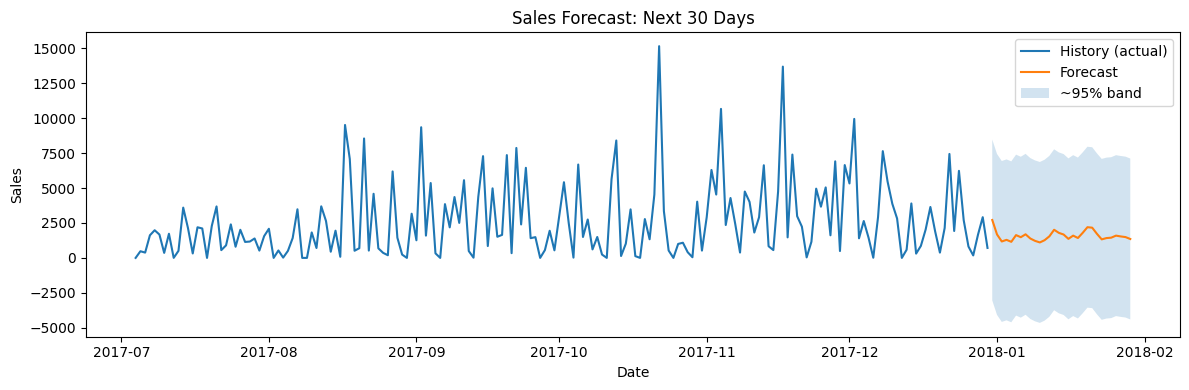

In [44]:
# Plot last 180 days of history + next 30 days forecast
window = 180
hist_tail = daily.tail(window).copy()

plt.figure(figsize=(12,4))
plt.plot(hist_tail["date"], hist_tail["sales"], label="History (actual)")
plt.plot(forecast_df["date"], forecast_df["forecast_sales"], label="Forecast")

# uncertainty band
plt.fill_between(forecast_df["date"], forecast_df["lower_95"], forecast_df["upper_95"], alpha=0.2, label="~95% band")

plt.title("Sales Forecast: Next 30 Days")
plt.xlabel("Date"); plt.ylabel("Sales")
plt.legend()
plt.tight_layout()
plt.show()


## 8) Business-friendly explanation (what this forecast means)


## 9) Export forecast to CSV (optional)



In [45]:
out_path = "forecast_next_30_days.csv"
forecast_df.to_csv(out_path, index=False)
print("Saved:", out_path)
forecast_df


Saved: forecast_next_30_days.csv


,date,forecast_sales,lower_95,upper_95
0,2017-12-31,2713.871540,-3046.249699,8473.992780
1,2018-01-01,1679.934297,-4080.186943,7440.055537
2,2018-01-02,1176.590488,-4583.530751,6936.711728
3,2018-01-03,1291.623286,-4468.497953,7051.744526
4,2018-01-04,1151.147076,-4608.974163,6911.268316
5,2018-01-05,1631.461598,-4128.659642,7391.582837
6,2018-01-06,1482.069568,-4278.051672,7242.190808
7,2018-01-07,1689.595729,-4070.525511,7449.716969
8,2018-01-08,1387.383341,-4372.737899,7147.504580
9,2018-01-09,1217.752241,-4542.368999,6977.873481


In [46]:
import os
os.makedirs("models", exist_ok=True)


In [47]:
import joblib

joblib.dump(ridge, "models/ridge_superstore.pkl")
joblib.dump(gbr,   "models/gbr_superstore.pkl")
joblib.dump(rf,    "models/rf_superstore.pkl")

print("Saved:")
print(" - models/ridge_superstore.pkl")
print(" - models/gbr_superstore.pkl")
print(" - models/rf_superstore.pkl")


Saved:
 - models/ridge_superstore.pkl
 - models/gbr_superstore.pkl
 - models/rf_superstore.pkl


In [48]:
import json

meta = {
    "models": {
        "Ridge": "models/ridge_superstore.pkl",
        "GradientBoostingRegressor": "models/gbr_superstore.pkl",
        "RandomForestRegressor": "models/rf_superstore.pkl",
        "Seasonal naive (lag_7)": None
    },
    "feature_cols": feature_cols,
    "date_col": "date",
    "target_col": "sales",
    "freq": "D",
    "test_days": int(test_days),
    "lags": [1, 7, 14, 28],
    "roll_windows": [7, 28]
}

with open("models/superstore_ml_meta.json", "w") as f:
    json.dump(meta, f, indent=2)

daily[["date","sales"]].to_csv("models/superstore_history_daily.csv", index=False)

print("Saved:")
print(" - models/superstore_ml_meta.json")
print(" - models/superstore_history_daily.csv")


Saved:
 - models/superstore_ml_meta.json
 - models/superstore_history_daily.csv
